# Import dataset

In [15]:
import tensorflow as tf
import keras 
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing

from sklearn.model_selection import train_test_split,GridSearchCV
import cv2 as cv
import time

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import load_model
from tensorflow.keras.models import Model


from tensorflow import keras
import tarfile
from shutil import copyfile

Collegamento a Google Drive il caricamento dei dati

https://www.kaggle.com/jehanbhathena/weather-dataset

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
copyfile('gdrive/My Drive/dataset.tar','dataset.tar')

tar= tarfile.open('dataset.tar')
tar.extractall()
tar.close()

In [18]:
def load_foto():
    maximages = 600
    labels = []
    foto = []
    dir='/content/dataset/'
    for f in sorted(os.listdir(dir)):
      for k, im in enumerate(sorted(os.listdir(dir + f))):
        if f !='rainbow' and im.endswith('.jpg') and im not in [ "4514.jpg" , "1187.jpg"] and k <maximages: 
          img = cv.imread( dir + f + '/' + im)
          img = cv.resize(img, (224,224), interpolation = cv.INTER_AREA)

          foto.append(img)
          label = f
          labels.append(label)
        
    X_train, X_test, y_train, y_test = train_test_split(foto, labels, test_size=0.2, random_state=1)

    return X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test=load_foto()

# Data Exploration

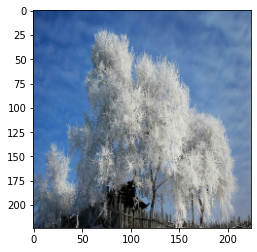

In [ ]:
plt.imshow(X_train[0][:,:,-1::-1])

In [ ]:
elements_count = {}
for element in y_train:
   if element in elements_count:
      elements_count[element] += 1
   else:
      elements_count[element] = 1
for key, value in elements_count.items():
   print(f"{key}: {value}")

rime: 491
fogsmog: 488
rain: 419
frost: 381
glaze: 466
lightning: 304
dew: 469
snow: 479
hail: 477
sandstorm: 479


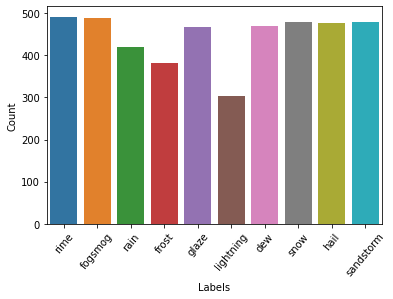

In [ ]:
sns.barplot(x=list(elements_count.keys()), y=list(elements_count.values()))
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [ ]:
elements_count = {}
for element in y_test:
   if element in elements_count:
      elements_count[element] += 1
   else:
      elements_count[element] = 1
for key, value in elements_count.items():
   print(f"{key}: {value}")

dew: 131
fogsmog: 111
snow: 120
hail: 114
rain: 107
lightning: 73
rime: 109
sandstorm: 121
frost: 94
glaze: 134


In [ ]:
path = '/content/dataset'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/content/dataset/rainbow/0653.jpg,rainbow
1,/content/dataset/rime/5493.jpg,rime
2,/content/dataset/frost/4070.jpg,frost
3,/content/dataset/fogsmog/4194.jpg,fogsmog
4,/content/dataset/rain/1570.jpg,rain


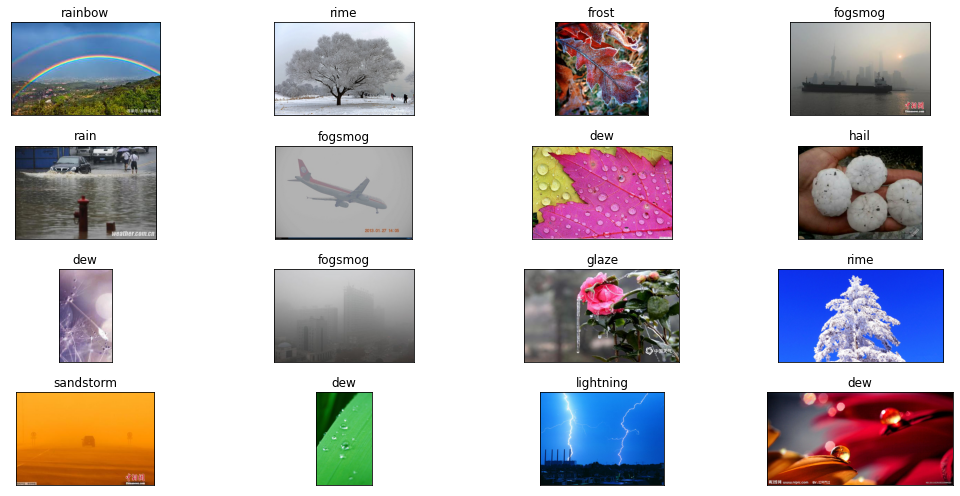

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

# Preprocessing

In [20]:
# preprocessing sui dati

X_train_nuovo = np.array(X_train)
X_test_nuovo =np.array(X_test)


#rendo le labels categoriche
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_train_nuovo = np_utils.to_categorical(y_train_enc, 10)
y_test_enc = encoder.fit_transform(y_test)
y_test_nuovo = np_utils.to_categorical(y_test_enc, 10)

#rinomino
#X_train=X_train_nuovo
#X_test= X_test_nuovo
#y_train=y_train_nuovo
#y_test=y_test_nuovo

# Il modello

Osservo il modello MobileNetV2

In [ ]:
model =tf.keras.applications.MobileNetV2(weights='imagenet', include_top=True, input_shape=(224,224,3))
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

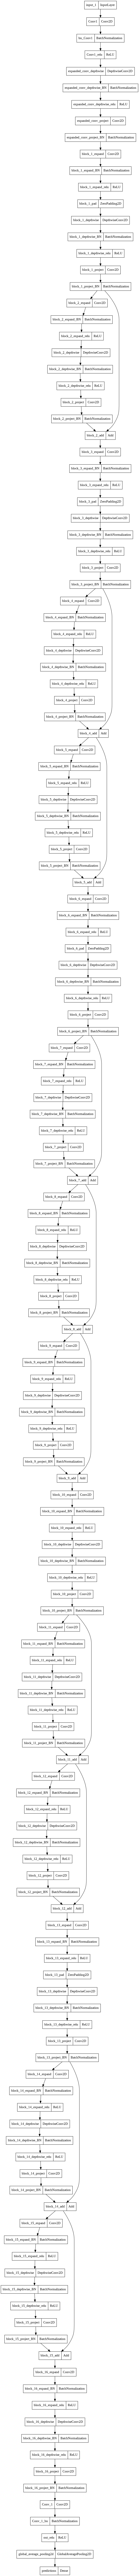

In [ ]:
keras.utils.plot_model(model)

Scelgo dove tagliare il modello addestrare su imagenet, si predilige un taglio abbastanza vicino all'output.

In [ ]:
model =tf.keras.applications.MobileNetV2(weights='imagenet', include_top=True, input_shape=(224,224,3))
model=keras.Model(inputs=model.input,
            outputs= model.get_layer('block_16_project_BN').output) 
 
  #model.summary()
for layer in model.layers:
    layer.trainable = False  


Layer aggiunti alla rete

In [ ]:
from keras.models import Sequential
from tensorflow.keras import regularizers

prova = Sequential()
prova.add(keras.Input(shape=(224,224,3)))

prova.add(keras.layers.RandomFlip("horizontal"))
prova.add(keras.layers.RandomRotation(0.3, fill_mode="nearest"))
prova.add(keras.layers.RandomZoom(0.5))
prova.add(keras.layers.RandomContrast(0.5))
prova.add(keras.layers.RandomTranslation(height_factor=(-0.2, 0.2),width_factor=(-0.2, 0.2)))

#preprocessing
prova.add(keras.layers.Rescaling(scale=1./127.5, offset=-1))

prova.add(model)

prova.add(keras.layers.MaxPooling2D((2, 2)))
prova.add(keras.layers.Conv2D(320, (3, 3), padding = "same", activation='relu'))


prova.add(keras.layers.Flatten())
prova.add(keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
prova.add(keras.layers.Dropout(0.4))

prova.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
prova.add(keras.layers.Dropout(0.4))
prova.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
prova.add(keras.layers.Dropout(0.4))

prova.add(keras.layers.Dense(10, activation='softmax'))
prova.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_4 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                                         
                                                                 
 random_translation_4 (Rando  (None, 224, 224, 3)      0         
 mTranslation)                                                   
                                                      

## Training del modello

In [ ]:
prova.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])
# Model training
network_history = prova.fit(X_train_nuovo, y_train_nuovo,
          epochs=50, batch_size=64,
          validation_split = 0.2
        );


Epoch 1/50
56/56 [==============================] - 18s 233ms/step - loss: 16.7990 - accuracy: 0.3523 - val_loss: 8.9303 - val_accuracy: 0.6184
Epoch 2/50
56/56 [==============================] - 12s 212ms/step - loss: 6.4112 - accuracy: 0.6131 - val_loss: 4.2061 - val_accuracy: 0.6790
Epoch 3/50
56/56 [==============================] - 12s 213ms/step - loss: 3.4646 - accuracy: 0.6982 - val_loss: 2.5489 - val_accuracy: 0.7531
Epoch 4/50
56/56 [==============================] - 12s 212ms/step - loss: 2.2768 - accuracy: 0.7395 - val_loss: 1.7753 - val_accuracy: 0.7755
Epoch 5/50
56/56 [==============================] - 12s 213ms/step - loss: 1.7405 - accuracy: 0.7431 - val_loss: 1.4801 - val_accuracy: 0.7598
Epoch 6/50
56/56 [==============================] - 12s 212ms/step - loss: 1.4486 - accuracy: 0.7518 - val_loss: 1.2161 - val_accuracy: 0.7980
Epoch 7/50
56/56 [==============================] - 12s 213ms/step - loss: 1.2693 - accuracy: 0.7647 - val_loss: 1.1091 - val_accuracy: 0.768

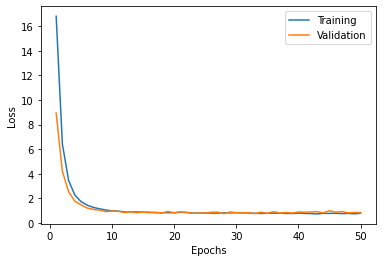

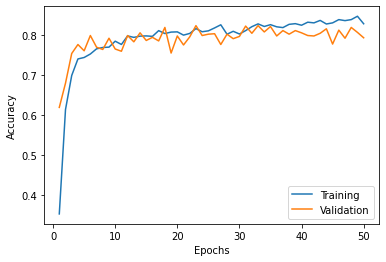

In [ ]:
from matplotlib import pyplot as plt
x_plot = list(range(1,50+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss']) 
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(network_history)

## Validazione del modello

In [ ]:
#accuracy sui dati di test
score1 = prova.evaluate(X_test_nuovo, y_test_nuovo)
score1

35/35 [==============================] - 3s 85ms/step - loss: 0.8213 - accuracy: 0.8241


[0.8213294148445129, 0.8240574598312378]

In [ ]:
prova.save('model_compl.h5') 

In [ ]:
#tempo di inferenza
t0 = time.time()
y_pred = prova.predict(X_test_nuovo)
t = time.time()-t0
print(t)

5.528380870819092


In [ ]:
y = encoder.inverse_transform(np.argmax(y_test_nuovo, axis=1))
y_pred =encoder.inverse_transform(np.argmax(y_pred, axis=1))

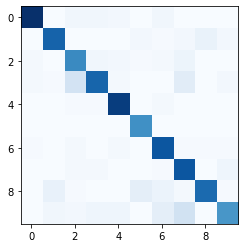

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y, y_pred)   
plt.imshow(cm, cmap=plt.cm.Blues)

In [ ]:
cm

array([[116,   0,   4,   4,   3,   0,   4,   0,   0,   0],
       [  0,  93,   0,   0,   0,   3,   1,   3,   8,   3],
       [  2,   0,  76,   4,   3,   1,   2,   6,   0,   0],
       [  2,   1,  21,  92,   2,   0,   0,  13,   0,   3],
       [  0,   0,   1,   1, 110,   0,   2,   0,   0,   0],
       [  0,   0,   0,   0,   0,  73,   0,   0,   0,   0],
       [  1,   0,   2,   0,   2,   0,  99,   1,   1,   1],
       [  0,   0,   2,   2,   0,   0,   1,  99,   0,   5],
       [  0,   9,   1,   0,   0,  11,   7,   2,  90,   1],
       [  0,   4,   3,   5,   5,   0,  11,  22,   0,  70]])

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         dew       0.96      0.89      0.92       131
     fogsmog       0.87      0.84      0.85       111
       frost       0.69      0.81      0.75        94
       glaze       0.85      0.69      0.76       134
        hail       0.88      0.96      0.92       114
   lightning       0.83      1.00      0.91        73
        rain       0.78      0.93      0.85       107
        rime       0.68      0.91      0.78       109
   sandstorm       0.91      0.74      0.82       121
        snow       0.84      0.58      0.69       120

    accuracy                           0.82      1114
   macro avg       0.83      0.83      0.82      1114
weighted avg       0.84      0.82      0.82      1114



L'accuracy del modello non è molto alta ma osservando la confusion 
matrix si vede che le classi maggiormente sbagliate sono  frost e glaze e rime che rappresentano delle condizioni simili e si osserva anche che la classe pioggia viene spesso sbagliata.

### Esempio di utilizzo

Provo a simulare l'output del modello, sia con un'immagine delle classi su cui è addestrato che su un immagine che non rappresenta fenomeni atmosferici che potrebbero impattare sulla guida.

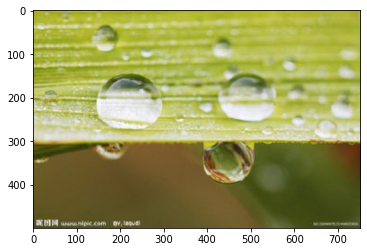

In [47]:
img = cv.imread('/content/2217.jpg')
plt.imshow(img[:,:,-1::-1])

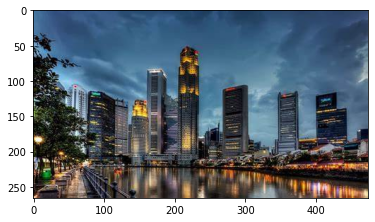

In [48]:
img2 = cv.imread('/content/bel_tempo_4.jpg')
plt.imshow(img2[:,:,-1::-1])

In [49]:
images=[]
image = cv.resize(img, (224,224), interpolation = cv.INTER_AREA)
images.append(image)
image = cv.resize(img2, (224,224), interpolation = cv.INTER_AREA)
images.append(image)

images=np.array(images)

In [50]:
img_pred = prova.predict(images)

In [52]:
img_cod=encoder.inverse_transform(np.argmax(img_pred, axis=1))

In [53]:
for i in range(len(img_pred)):
  if img_pred[i].max() >=  0.7:
     print("Attention:", img_cod[i] )
  elif img_pred[i].max()< 0.7 and img_pred[i].max() >= 0.5:
     print("Not sure but the most probable is:", img_cod[i])
  else:
    print("Not bad weather")

Attention: dew
Not bad weather


Il modello predice correttamente entrambe le immagini

# Pruning

In [ ]:
!git clone https://github.com/Hahn-Schickard/Automatic-Structured-Pruning
!echo $CWD
!cp -rf /content/Automatic-Structured-Pruning/* /content/

#The Framework work with Tensorflow 2.1-2.3.1
import Pruning

fatal: destination path 'Automatic-Structured-Pruning' already exists and is not an empty directory.



Si effettuano iterativamente 4 pruning del modello e ogni volta viene riaddestrato per far adattare i pesi rimanenti.

## Pruning 1

In [ ]:
Denseprunerate=10

Convprunerate=5
import Pruning
prunemodel=Pruning.prune_model('./model_compl.h5',Denseprunerate, Convprunerate,'L2', num_classes=10, label_one_hot=True)

/content/Pruning.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(layer_types), np.array(layer_params), layer_output_shape, layer_bias


Finish with pruning
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
Conv2D
No Dense or Conv2D
Dense
No Dense or Conv2D
Dense
No Dense or Conv2D
Dense
Before pruning:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_4 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                        

In [ ]:
prunemodel.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])
# Model training
network_history = prunemodel.fit(X_train_nuovo, y_train_nuovo,
          epochs=20, batch_size=64,
          validation_split = 0.2
        );


Epoch 1/20
56/56 [==============================] - 18s 243ms/step - loss: 0.9196 - accuracy: 0.7894 - val_loss: 0.9113 - val_accuracy: 0.7924
Epoch 2/20
56/56 [==============================] - 12s 213ms/step - loss: 0.7870 - accuracy: 0.8355 - val_loss: 0.8742 - val_accuracy: 0.8137
Epoch 3/20
56/56 [==============================] - 12s 213ms/step - loss: 0.7380 - accuracy: 0.8445 - val_loss: 0.9048 - val_accuracy: 0.8215
Epoch 4/20
56/56 [==============================] - 12s 214ms/step - loss: 0.7726 - accuracy: 0.8335 - val_loss: 0.8737 - val_accuracy: 0.8025
Epoch 5/20
56/56 [==============================] - 12s 214ms/step - loss: 0.7877 - accuracy: 0.8268 - val_loss: 0.8487 - val_accuracy: 0.8025
Epoch 6/20
56/56 [==============================] - 12s 213ms/step - loss: 0.7771 - accuracy: 0.8344 - val_loss: 0.8372 - val_accuracy: 0.8171
Epoch 7/20
56/56 [==============================] - 12s 214ms/step - loss: 0.7701 - accuracy: 0.8358 - val_loss: 0.9001 - val_accuracy: 0.8114

In [ ]:
score2 = prunemodel.evaluate(X_test_nuovo, y_test_nuovo)
score2

35/35 [==============================] - 3s 86ms/step - loss: 0.9510 - accuracy: 0.8052


[0.9510207772254944, 0.8052064776420593]

In [ ]:
prunemodel.save('prune.h5') 

## Pruning 2

In [ ]:
Denseprunerate=10

Convprunerate=5
import Pruning
prunemodel=Pruning.prune_model(prunemodel,Denseprunerate, Convprunerate,'L2', num_classes=10, label_one_hot=True)

/content/Pruning.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(layer_types), np.array(layer_params), layer_output_shape, layer_bias


Finish with pruning
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
Conv2D
No Dense or Conv2D
Dense
No Dense or Conv2D
Dense
No Dense or Conv2D
Dense
Before pruning:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_4 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                        

In [ ]:
prunemodel.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])
# Model training
network_history = prunemodel.fit(X_train_nuovo, y_train_nuovo,
          epochs=20, batch_size=64,
          validation_split = 0.2
        );


Epoch 1/20
56/56 [==============================] - 18s 234ms/step - loss: 0.8794 - accuracy: 0.8012 - val_loss: 0.8564 - val_accuracy: 0.8215
Epoch 2/20
56/56 [==============================] - 12s 212ms/step - loss: 0.7216 - accuracy: 0.8512 - val_loss: 0.9152 - val_accuracy: 0.8058
Epoch 3/20
56/56 [==============================] - 12s 213ms/step - loss: 0.7093 - accuracy: 0.8523 - val_loss: 0.8292 - val_accuracy: 0.8204
Epoch 4/20
56/56 [==============================] - 12s 224ms/step - loss: 0.7136 - accuracy: 0.8582 - val_loss: 0.8959 - val_accuracy: 0.7991
Epoch 5/20
56/56 [==============================] - 12s 213ms/step - loss: 0.7071 - accuracy: 0.8582 - val_loss: 0.8941 - val_accuracy: 0.8070
Epoch 6/20
56/56 [==============================] - 12s 213ms/step - loss: 0.7431 - accuracy: 0.8450 - val_loss: 0.8710 - val_accuracy: 0.8249
Epoch 7/20
56/56 [==============================] - 12s 215ms/step - loss: 0.7138 - accuracy: 0.8498 - val_loss: 0.9276 - val_accuracy: 0.8092

In [ ]:
score3 = prunemodel.evaluate(X_test_nuovo, y_test_nuovo)
score3

35/35 [==============================] - 3s 88ms/step - loss: 0.9498 - accuracy: 0.8196


[0.9498233199119568, 0.8195691108703613]

In [ ]:
prunemodel.save('prune2.h5') 

## Pruning 3

In [ ]:
Denseprunerate=10

Convprunerate=5
import Pruning
prunemodel=Pruning.prune_model(prunemodel,Denseprunerate, Convprunerate,'L2', num_classes=10, label_one_hot=True)

/content/Pruning.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(layer_types), np.array(layer_params), layer_output_shape, layer_bias


Finish with pruning
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
Conv2D
No Dense or Conv2D
Dense
No Dense or Conv2D
Dense
No Dense or Conv2D
Dense
Before pruning:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_4 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                        

In [ ]:
prunemodel.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])
# Model training
network_history = prunemodel.fit(X_train_nuovo, y_train_nuovo,
          epochs=20, batch_size=128,
          validation_split = 0.2
        );


Epoch 1/20
28/28 [==============================] - 18s 456ms/step - loss: 0.9262 - accuracy: 0.7945 - val_loss: 0.7970 - val_accuracy: 0.8305
Epoch 2/20
28/28 [==============================] - 11s 411ms/step - loss: 0.6861 - accuracy: 0.8622 - val_loss: 0.8835 - val_accuracy: 0.8002
Epoch 3/20
28/28 [==============================] - 11s 411ms/step - loss: 0.6255 - accuracy: 0.8675 - val_loss: 0.7936 - val_accuracy: 0.8227
Epoch 4/20
28/28 [==============================] - 11s 411ms/step - loss: 0.6137 - accuracy: 0.8661 - val_loss: 0.8763 - val_accuracy: 0.8081
Epoch 5/20
28/28 [==============================] - 11s 412ms/step - loss: 0.6293 - accuracy: 0.8633 - val_loss: 0.9254 - val_accuracy: 0.7980
Epoch 6/20
28/28 [==============================] - 11s 412ms/step - loss: 0.6521 - accuracy: 0.8610 - val_loss: 0.8033 - val_accuracy: 0.8215
Epoch 7/20
28/28 [==============================] - 11s 413ms/step - loss: 0.6053 - accuracy: 0.8773 - val_loss: 0.8825 - val_accuracy: 0.8171

In [ ]:
score4 = prunemodel.evaluate(X_test_nuovo, y_test_nuovo)
score4

35/35 [==============================] - 3s 88ms/step - loss: 0.8347 - accuracy: 0.8250


[0.8346893787384033, 0.8249551057815552]

In [ ]:
prunemodel.save('prune3.h5') 

## Pruning 4

In [ ]:
Denseprunerate=10

Convprunerate=5
import Pruning
prunemodel=Pruning.prune_model(prunemodel,Denseprunerate, Convprunerate,'L2', num_classes=10, label_one_hot=True)

/content/Pruning.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(layer_types), np.array(layer_params), layer_output_shape, layer_bias


Finish with pruning
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
No Dense or Conv2D
Conv2D
No Dense or Conv2D
Dense
No Dense or Conv2D
Dense
No Dense or Conv2D
Dense
Before pruning:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_4 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                        

In [ ]:
prunemodel.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])
# Model training
network_history = prunemodel.fit(X_train_nuovo, y_train_nuovo,
          epochs=20, batch_size=128,
          validation_split = 0.2
        );


Epoch 1/20
28/28 [==============================] - 17s 458ms/step - loss: 0.8495 - accuracy: 0.7903 - val_loss: 0.9304 - val_accuracy: 0.7991
Epoch 2/20
28/28 [==============================] - 11s 411ms/step - loss: 0.6311 - accuracy: 0.8731 - val_loss: 0.8812 - val_accuracy: 0.8148
Epoch 3/20
28/28 [==============================] - 11s 411ms/step - loss: 0.6037 - accuracy: 0.8782 - val_loss: 0.8737 - val_accuracy: 0.8081
Epoch 4/20
28/28 [==============================] - 11s 410ms/step - loss: 0.5888 - accuracy: 0.8832 - val_loss: 0.9157 - val_accuracy: 0.8182
Epoch 5/20
28/28 [==============================] - 11s 411ms/step - loss: 0.5964 - accuracy: 0.8759 - val_loss: 0.8090 - val_accuracy: 0.8294
Epoch 6/20
28/28 [==============================] - 11s 411ms/step - loss: 0.5862 - accuracy: 0.8742 - val_loss: 0.8744 - val_accuracy: 0.8137
Epoch 7/20
28/28 [==============================] - 11s 412ms/step - loss: 0.6030 - accuracy: 0.8796 - val_loss: 0.8645 - val_accuracy: 0.8227

In [ ]:
score5 = prunemodel.evaluate(X_test_nuovo, y_test_nuovo)
score5

35/35 [==============================] - 3s 87ms/step - loss: 0.8186 - accuracy: 0.8384


[0.818554162979126, 0.8384200930595398]

In [ ]:
prunemodel.save('prune4.h5') 

## grafico pruning vs accuracy, 4 cicli di pruning

In [ ]:
scores = [score1[1],score2[1], score3[1], score4[1],score5[1]]

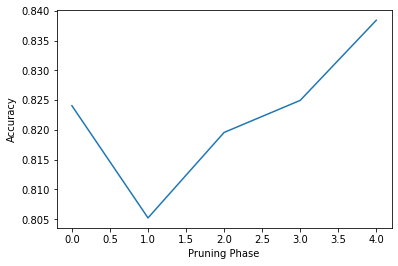

In [ ]:
from matplotlib import pyplot as plt
x_plot = list(range(0,4+1))

def plot_pruning(scores):
    
    plt.figure()
    plt.xlabel('Pruning Phase')
    plt.ylabel('Accuracy')
    plt.plot(x_plot,scores)
    plt.show()


plot_pruning(scores)

In [ ]:
y_pred = prunemodel.predict(X_test_nuovo)

tempo di esecuzione del modello con pruning

In [ ]:
t0 = time.time()
y_pred = prunemodel.predict(X_test_nuovo)
t = time.time()-t0
print(t)

2.8982129096984863


tempo di esecuzione del modello senza pruning

In [ ]:
t0 = time.time()
y_pred = prova.predict(X_test_nuovo)
t = time.time()-t0
print(t)

5.214488983154297


### Esempio di utilizzo: ripeto l'esperimento di prima

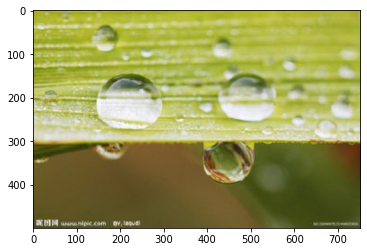

In [7]:
img = cv.imread('/content/2217.jpg')
plt.imshow(img[:,:,-1::-1])

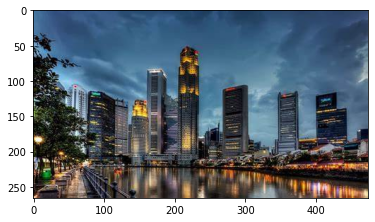

In [39]:
img2 = cv.imread('/content/bel_tempo_4.jpg')
plt.imshow(img2[:,:,-1::-1])

In [40]:
images=[]
image = cv.resize(img, (224,224), interpolation = cv.INTER_AREA)
images.append(image)
image = cv.resize(img2, (224,224), interpolation = cv.INTER_AREA)
images.append(image)

images=np.array(images)

In [42]:
img_pred = prunemodel.predict(images)

In [43]:
img_pred

array([[1.0000000e+00, 1.6394413e-20, 3.6376415e-16, 1.8181791e-15,
        3.0015038e-15, 1.1480777e-21, 1.1067660e-19, 2.5233122e-28,
        2.4396953e-21, 4.4471904e-28],
       [3.3872663e-03, 2.4300650e-02, 5.5296443e-02, 2.9457653e-01,
        4.1915760e-03, 1.2034507e-03, 8.8914149e-03, 4.3244126e-01,
        8.8068256e-03, 1.6690458e-01]], dtype=float32)

In [44]:
img_cod=encoder.inverse_transform(np.argmax(img_pred, axis=1))

In [45]:
for i in range(len(img_pred)):
  if img_pred[i].max() >=  0.7:
     print("Attention:", img_cod[i] )
  elif img_pred[i].max()< 0.7 and img_pred[i].max() >= 0.5:
     print("Not sure but the most probable is:", img_cod[i])
  else:
    print("Not bad weather")

Attention: dew
Not bad weather


Il modello continua a restituire i risultati esatti.

#Quantizzazione


Si effettua la quantizzazione e la conversione del modello in tflite.

In [ ]:
!pip install tensorflow_model_optimization

     |████████████████████████████████| 234 kB 5.3 MB/s 


In [ ]:
model = tf.keras.models.load_model('/content/prune4.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
#saving converted model in "converted_quant_model.tflite" file
open("converted_quant_model.tflite", "wb").write(tflite_quant_model)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
#saving converted model in "converted_model.tflite" file
open("converted_model.tflite", "wb").write(tflite_model)


17651276

In [ ]:
import os
print("Float model in Mb:", os.path.getsize('converted_model.tflite') / float(2**20))
print("Quantized model in Mb:", os.path.getsize('converted_quant_model.tflite') / float(2**20))
print("Compression ratio:", os.path.getsize('converted_model.tflite')/os.path.getsize('converted_quant_model.tflite'))

Float model in Mb: 16.833568572998047
Quantized model in Mb: 4.61383056640625
Compression ratio: 3.64850168004974


In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_quant_model.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Test model on some input data.
input_shape = input_details[0]['shape']
acc=0
for i in range(len(X_test_nuovo)):
    input_data = X_test_nuovo[i].reshape(input_shape)
    input_data = input_data.astype('float32')
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    if(np.argmax(output_data) == np.argmax(y_test_nuovo[i])):
        acc+=1
acc = acc/len(X_test_nuovo)
print(acc*100)

83.84201077199282


acc iniziale: 0.8240574598312378
